In [1]:
import cv2
import os
import numpy as np
from tqdm import tqdm  # For progress bar

# Define paths
INPUT_FOLDER = r"C:\stse\sem8\SDP\dataset_images"
OUTPUT_FOLDER = r"C:\stse\sem8\SDP\preprocessed_images"
IMG_SIZE = (224, 224)  # Resize to 224x224

# Create output folder if it doesn't exist
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Process each image
for img_name in tqdm(os.listdir(INPUT_FOLDER)):
    img_path = os.path.join(INPUT_FOLDER, img_name)
    
    # Read the image
    img = cv2.imread(img_path)
    
    # Resize the image
    img_resized = cv2.resize(img, IMG_SIZE)
    
    # Save resized image
    output_path = os.path.join(OUTPUT_FOLDER, img_name)
    cv2.imwrite(output_path, img_resized)

print("Image resizing complete! ✅")


100%|██████████| 10015/10015 [04:40<00:00, 35.65it/s]

Image resizing complete! ✅


In [2]:
# Process each image
for img_name in tqdm(os.listdir(OUTPUT_FOLDER)):  # Use preprocessed folder now
    img_path = os.path.join(OUTPUT_FOLDER, img_name)
    
    # Read image
    img = cv2.imread(img_path)
    
    # Convert image to float and normalize to [0,1] range
    img_normalized = img.astype(np.float32) / 255.0  
    
    # Save normalized image (optional: scale back to 0-255 for saving)
    img_save = (img_normalized * 255).astype(np.uint8)
    cv2.imwrite(img_path, img_save)

print("Image normalization complete! ✅")


100%|██████████| 10015/10015 [02:21<00:00, 70.70it/s]

Image normalization complete! ✅


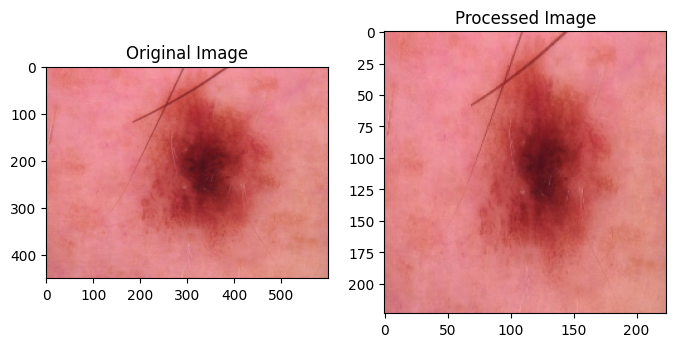

In [5]:
import matplotlib.pyplot as plt

# Load and display original & preprocessed images
sample_img = r"C:\stse\sem8\SDP\dataset_images\ISIC_0024306.jpg"
processed_img = r"C:\stse\sem8\SDP\preprocessed_images\ISIC_0024306.jpg"

orig = cv2.imread(sample_img)
proc = cv2.imread(processed_img)

# Convert BGR to RGB (for correct display in matplotlib)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB)
proc = cv2.cvtColor(proc, cv2.COLOR_BGR2RGB)

# Show images side by side
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(orig)
plt.title("Original Image")

plt.subplot(1,2,2)
plt.imshow(proc)
plt.title("Processed Image")

plt.show()


## image reading, resizing, normlization and comparision are done

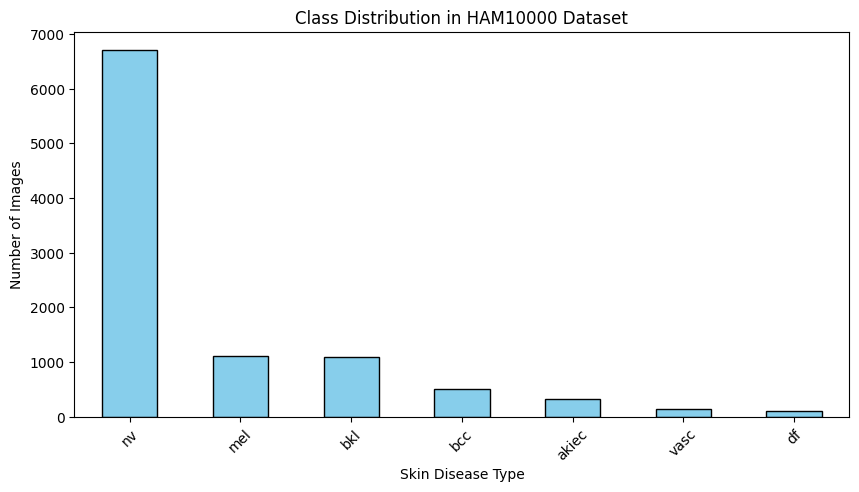

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load metadata CSV
df = pd.read_csv(r"C:\stse\sem8\SDP\dataset_images\HAM10000_metadata.csv")

# Count instances per class
class_counts = df['dx'].value_counts()

# Plot class distribution
plt.figure(figsize=(10,5))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel("Skin Disease Type")
plt.ylabel("Number of Images")
plt.title("Class Distribution in HAM10000 Dataset")
plt.xticks(rotation=45)
plt.show()


In [2]:
import cv2
import os
import numpy as np
import albumentations as A
from tqdm import tqdm
import pandas as pd

# Load metadata CSV
df = pd.read_csv(r"C:\stse\sem8\SDP\preprocessed_images\HAM10000_metadata.csv")

# Define augmentation transformations
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.3),
    A.Rotate(limit=15, p=0.5),
    A.GaussNoise(var_limit=(10, 30), p=0.3),
])

# Define paths
INPUT_FOLDER = r"C:\stse\sem8\SDP\dataset_images"
AUGMENTED_FOLDER = r"C:\stse\sem8\SDP\balanced_images"
os.makedirs(AUGMENTED_FOLDER, exist_ok=True)

# Get class counts
class_counts = df["dx"].value_counts()
max_class_size = class_counts.max()  # The largest class size

# Create a new dataframe to track augmented images
augmented_data = []

# Process each class separately
for class_label, count in class_counts.items():
    class_images = df[df["dx"] == class_label]
    
    # Copy original images to new folder
    for _, row in class_images.iterrows():
        img_name = row["image_id"] + ".jpg"
        img_path = os.path.join(INPUT_FOLDER, img_name)
        
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            cv2.imwrite(os.path.join(AUGMENTED_FOLDER, img_name), img)
            augmented_data.append(row)  # Save original data entry

    # Augment until the class matches max_class_size
    num_augmentations_needed = max_class_size - count
    augment_per_image = num_augmentations_needed // count + 1  # Augment each image multiple times

    for _, row in tqdm(class_images.iterrows(), total=len(class_images)):
        img_name = row["image_id"] + ".jpg"
        img_path = os.path.join(INPUT_FOLDER, img_name)
        
        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        for j in range(augment_per_image):
            if num_augmentations_needed <= 0:
                break  # Stop when enough images are generated

            augmented = augmentations(image=img)["image"]
            aug_img_name = f"{row['image_id']}_aug{j}.jpg"
            aug_img_path = os.path.join(AUGMENTED_FOLDER, aug_img_name)
            cv2.imwrite(aug_img_path, cv2.cvtColor(augmented, cv2.COLOR_RGB2BGR))

            # Save the augmented data entry
            new_row = row.copy()
            new_row["image_id"] = aug_img_name.replace(".jpg", "")
            augmented_data.append(new_row)
            
            num_augmentations_needed -= 1

# Save the new balanced dataset metadata
balanced_df = pd.DataFrame(augmented_data)
balanced_df.to_csv(r"C:\stse\sem8\SDP\balanced_images\balanced_HAM10000_metadata.csv", index=False)

print("Dataset successfully balanced! ✅")


C:\Users\Sudharshan Pulipaka\AppData\Local\Temp\ipykernel_14036\3099421798.py:17: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10, 30), p=0.3),
100%|██████████| 115/115 [00:45<00:00,  2.52it/s]


Dataset successfully balanced! ✅


## image balancing using augmentation done

In [3]:
import cv2
import os
import numpy as np
from tqdm import tqdm

# Path to augmented dataset
AUGMENTED_FOLDER = r"C:\stse\sem8\SDP\balanced_images"
OUTPUT_FOLDER = r"C:\stse\sem8\SDP\balanced_and_standardized_images"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Process each image
for img_name in tqdm(os.listdir(AUGMENTED_FOLDER)):
    img_path = os.path.join(AUGMENTED_FOLDER, img_name)
    
    # Read image
    img = cv2.imread(img_path)
    if img is None:
        continue
    
    # Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    # Extract L, A, B channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge back LAB channels
    lab = cv2.merge([l, a, b])

    # Convert back to BGR for saving
    standardized_img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

    # Save the new image
    cv2.imwrite(os.path.join(OUTPUT_FOLDER, img_name), standardized_img)

print("Color space standardization complete! ✅")


100%|██████████| 46936/46936 [14:43<00:00, 53.14it/s]

Color space standardization complete! ✅
